In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'


Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [125]:
shift = Q = lambda d,z: sum([1/d * cos(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)
L0 = lambda d,z: sum([-2*pi*p/d**2 * sin(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)

# cosine correlation 
coscorr = lambda x,y: trace(x.T@y)/norm(x)/norm(y)

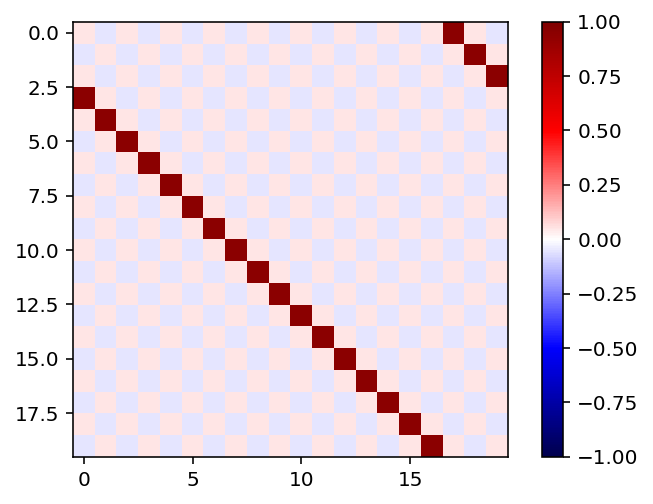

In [5]:
d = 20
m = 3
z = arange(d)[:,newaxis]-arange(d)
imshow(Q(d,z-m), cmap = 'seismic',vmin=-1, vmax=1)
colorbar()

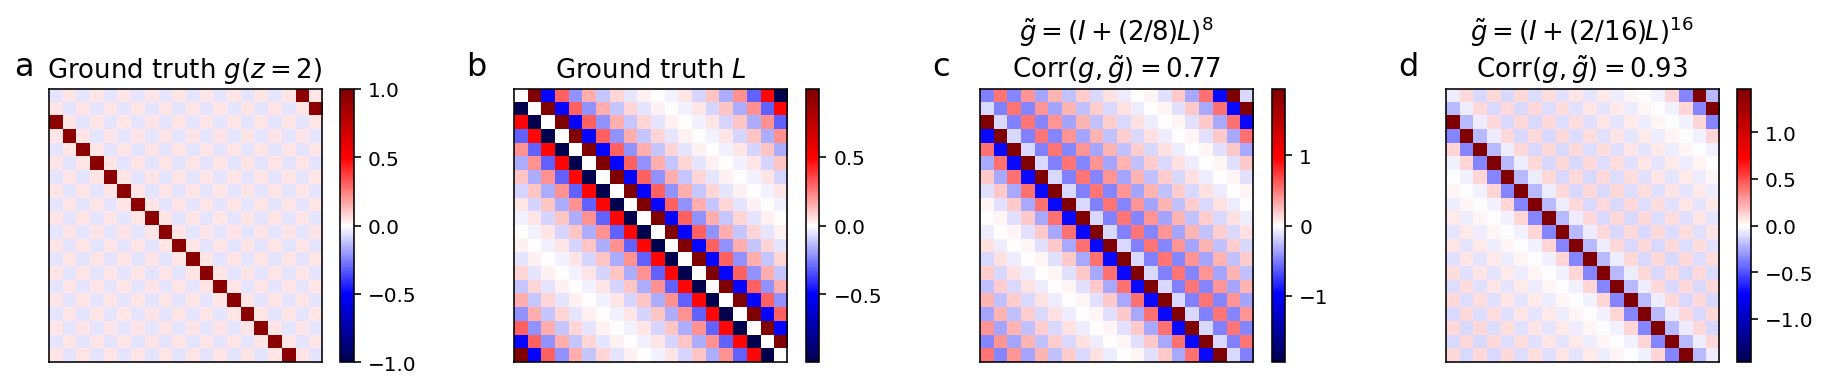

In [126]:
d = 20
m = 2
ns = array([4,8])*m
labs = '0abcde'

mx = 2
z = arange(d)[:,newaxis]-arange(d)
ii=0
figure(figsize=(13,2.7))
ii+=1
subplot(1,len(ns)+2,ii)
text(-3,-1.5,labs[ii], fontdict={'size':16,'weight':1})

a=Q(d,z-m)
mx=max(abs(a.ravel()))
imshow(a, cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'Ground truth $g(z=%d)$'%m, size=13)
xticks([])
yticks([])

ii+=1
subplot(1,len(ns)+2,ii)
text(-4,-1.5,labs[ii], fontdict={'size':16,'weight':1})

a=L0(d,z)
mx=max(abs(a.ravel()))
imshow(a, cmap = 'seismic',vmin=-mx, vmax=mx)
colorbar()
title(r'Ground truth $L$',size=13)
xticks([])
yticks([])


for n in ns:
    ii+=1
    subplot(1,len(ns)+2,ii)
    text(-4,-1.5,labs[ii], fontdict={'size':16,'weight':1})

    a=matrix_power(eye(d)-m/n* L0(d,z),n)
    mx = max(abs(a.ravel()))
    imshow(a, cmap = 'seismic',vmin=-mx, vmax=mx)
    colorbar()
#     overlap = trace(a.T@Q(d,z-m))/norm(a)/norm(Q(d,z-m))
    overlap = coscorr(a,Q(d,z-m))
    title(r'$\tilde{g}=(I+(%d/%d)L)^{%d}$'%(m,n,n)+'\nCorr'+r'$(g,\tilde{g})=%.2f$'%(overlap),size=13)
    xticks([])
    yticks([])
    
tight_layout()
# savefig('figs2/shift-1D-example.pdf')
# savefig('figs2/shift-1D-example.png',dpi=300)


### Correlation with random  

In [128]:
r = randn(*a.shape)
# trace(r.T@Q(d,z-m))/norm(r)/norm(Q(d,z-m))
coscorr(r, Q(d,z-m))

-0.03139264271799015

In [127]:
# trace(L0(d,z).T@Q(d,z-m))/norm(L0(d,z))/norm(Q(d,z-m))
coscorr(L0(d,z), Q(d,z-m))

0.2957397716093291

# Exact rotation generator
$\newcommand{\ro}{\partial}$
We can use $L$ from 1D translations as $\ro_x$ and $\ro_y$. 
We use this to construct the groun truth rotation generator $L_\theta = x\ro_y - y\ro_x$.


In [10]:
L0 = lambda d,z: sum([2*pi*p/d**2 * sin(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)

### Image dimensions

In [153]:
DIM = 7

### double the width and height
Rotation in pytorch double the $h,w$ (height and width) extent to perform the affine transform. 
Therefore, we need to use $2h$ and $2w$ in $L$. 

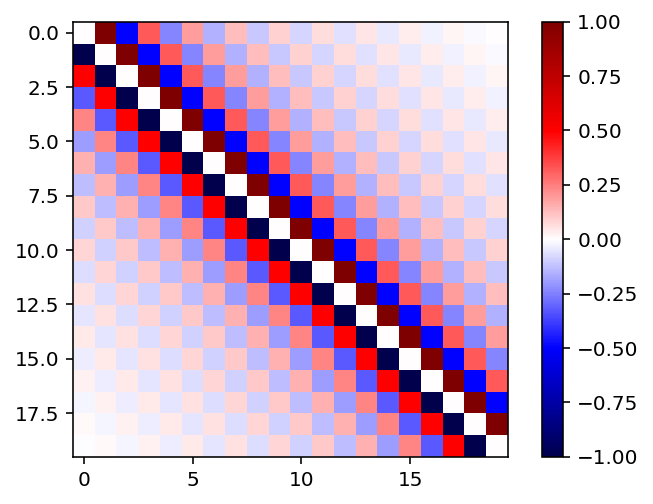

In [105]:
d = 20
z = arange(d)[:,newaxis]-arange(d)
imshow(L0(2*d,z), cmap = 'seismic',vmin=-1, vmax=1)
colorbar()

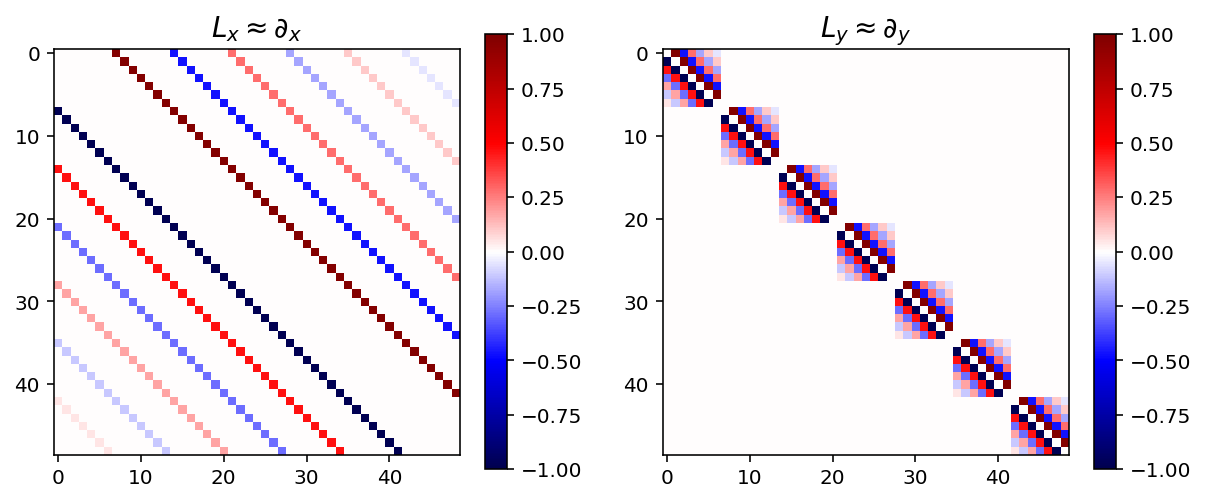

In [154]:
d = DIM
coords = mgrid[:d,:d] - d/2
x,y = coords.reshape((2,-1))

dx = (x[:,newaxis]-x) * (y[:,newaxis]==y) # make sure distance calculated only for the same y
dy = (y[:,newaxis]-y) * (x[:,newaxis]==x) # ... same x

figure(figsize=(10,4))
subplot(121)

Lx = L0(2*d,dx)
imshow(Lx,cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'$L_x\approx \partial_x$',size=14)

subplot(122)

Ly = L0(2*d,dy)
imshow(Ly,cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'$L_y\approx \partial_y$',size=14);


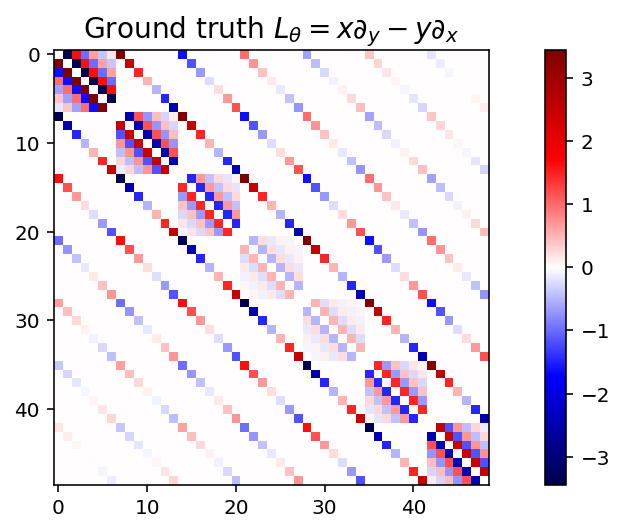

In [155]:

figure(figsize=(10,4))

yLx = diag(y) @ Lx
xLy = diag(x) @ Ly

L_rot = xLy - yLx
imshow(L_rot,cmap = 'seismic')#,vmin=-1, vmax=1)
colorbar()
title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);

# Trainer

In [186]:
from time import time
class trainer():
    def __init__(self, model, device, optimizer, dataset_class = None, 
                 train_loader=None, test_loader=None,
                 batch_size = 64, test_batch_size = 1000,loss_func = F.nll_loss,
                ):
        """
        usage:
            t = trainer(...)
            t.fit(epochs)
            
        methods:
            .fit(epochs) : train + test; print results; stores results in trainer.history <dict>
            .train(epoch)
            .test()
        """
        self.device = device #torch.device(device)
        self.optimizer = optimizer
        self.model = model
        self.loss_func = loss_func

        self.scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        self.history = {'train loss':[], 'test loss':[], 'train acc':[], 'test acc':[], 'train time':[]}
        
        if dataset_class:
            self.make_dataloaders(dataset_class, batch_size, test_batch_size)
        else:
            self.train_loader = train_loader 
            self.test_loader = test_loader
        
    def make_dataloaders(self, dataset_class, batch_size, test_batch_size):
        train_kwargs = {'batch_size': batch_size}
        test_kwargs = {'batch_size': test_batch_size}
        if self.device.type =='cuda':        
            cuda_kwargs = {'num_workers': 1,
                           'pin_memory': True,
                           'shuffle': True}
            train_kwargs.update(cuda_kwargs)
            test_kwargs.update(cuda_kwargs)
        
        print('Creating data loaders...',end='')
        dataset1 = dataset_class('../data', train=True, download=True,)
        dataset2 = dataset_class('../data', train=False,)

        self.train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
        self.test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        print('Done')

#         self.optimizer = optimizer
#         self.model, self.device, self.train_loader,  = model, device, train_loader,
#         self.test_loader = test_loader
        
    def progbar(self,percent, N=10):
        n = int(percent//N)
        return '[' + '='*n + '>' +'.'*(N-n-1) +']'
    
    def train(self,epoch):
        self.model.train()
        training_loss = 0
        correct = 0
        t0 = time()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            if type(data)==list:
                data = [d.to(self.device) for d in data]
            else:
                data = data.to(self.device)
            if type(target)==list:
                target = [d.to(self.device) for d in target]
            else:
                target = target.to(self.device)
                
#             data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            training_loss += loss.sum().item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss.backward(retain_graph=True)
            self.optimizer.step()
            if batch_idx % 10 == 0:
                perc = 100. * batch_idx / len(self.train_loader)
                t1 = time()
                print('Train Epoch: {} {} {:.1f}s [{}/{} ({:.0f}%)]\tLoss: {:.4g}'.format(
                    epoch, self.progbar(perc), t1-t0,
                    batch_idx * len(data), len(self.train_loader.dataset), # n/N
                    perc, # % passed
                    loss.item()), end='\r')
        
        training_loss /= len(self.train_loader.dataset)
        acc = correct / len(self.train_loader.dataset)    
        print('\nTraining: loss: {:.4g}, Acc: {:.2f}%'.format(training_loss, 100.*acc))
            
        return {'loss':training_loss, 'acc':acc , 'time':t1-t0}
                
        
    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                if type(data)==list:
                    data = [d.to(self.device) for d in data]
                else:
                    data = data.to(self.device)
                if type(target)==list:
                    target = [d.to(self.device) for d in target]
                else:
                    target = target.to(self.device)
                #data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += self.loss_func(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        
        test_loss /= len(self.test_loader.dataset)
        test_acc = correct / len(self.test_loader.dataset)
        
        print('Test loss: {:.4g}, Test acc.: {:.2f}%'.format( test_loss, 100.*test_acc))
        return {'loss':test_loss, 'acc':test_acc}
    
    def fit(self,epochs=1):
        for epoch in range(1, epochs + 1):
            r = self.train(epoch)
            self.history['train loss'] += [r['loss']]
            self.history['train acc'] += [r['acc']]
            self.history['train time'] += [r['time']]
            
            r = self.test()
            self.history['test loss'] += [r['loss']]
            self.history['test acc'] += [r['acc']]
            self.scheduler.step()

# L-conv funcs

In [122]:
# includes residual
       
class Lconv_core(nn.Module):
    """ L-conv layer with full L """
    def __init__(self,d,num_L=1,cin=1,cout=1,rank=8):
        """
        L:(num_L, d, d)
        Wi: (num_L, cout, cin)
        """
        super().__init__()
        self.L = nn.Parameter(torch.Tensor(num_L, d, d))
        self.Wi = nn.Parameter(torch.Tensor(num_L, cout, cin))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L) 
        nn.init.kaiming_normal_(self.Wi)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        # h = (x + Li x Wi) W0
        y = torch.einsum('kdf,bcf,koc->bod', self.L, x, self.Wi ) +x #+ self.b        
        return y


In [123]:
# includes residual

class Lconv_grid(nn.Module):
    """ L-conv using an inferred grid in the data. 
    """
    def __init__(self,idx, k,d,cin,cout):
        super().__init__()
        self.idx = idx
        self.L_sparse = nn.Parameter(torch.Tensor(*idx.shape, k)) 
        self.W = nn.Parameter(torch.Tensor(k, cin, cout))
        self.b = nn.Parameter(torch.Tensor(1, cout, 1))
        # the bias is not complete, but more efficient 
#         self.b = nn.Parameter(torch.Tensor(1,k, cout, 1))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L_sparse, mode='fan_in') 
        nn.init.kaiming_normal_(self.W)      
        nn.init.kaiming_normal_(self.b)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        return torch.einsum('bcdi,dik,kco->bod',x[:,:,self.idx], self.L_sparse, self.W ) + self.b


In [124]:
class Reshape(nn.Module):
    def __init__(self,shape=None):
        self.shape = shape
        super().__init__()
    def forward(self,x):
        return x.view(-1,*self.shape)

# Datasets

In [149]:
class FixedRot(datasets.VisionDataset):
    num_targets = 10
    def __init__(self,*args,angle =pi/3,N=50000,size=(7,7),
                 train=True,dataseed=0,**kwargs):
        super().__init__(*args,**kwargs)
        if not train: 
            dataseed += 1
            N = int(0.2*N)
        torch.manual_seed(dataseed)
        angles = torch.ones(N)*angle # torch.rand(N)*2*np.pi
        self.data = torch.rand(N,1,*size)-.5
        print(N, self.data.shape)
        with torch.no_grad():
            # Build affine matrices for random translation of each image
            affineMatrices = torch.zeros(N,2,3)
            affineMatrices[:,0,0] = angles.cos()
            affineMatrices[:,1,1] = angles.cos()
            affineMatrices[:,0,1] = angles.sin()
            affineMatrices[:,1,0] = -angles.sin()
            # affineMatrices[:,0,2] = -2*np.random.randint(-self.max_trans, self.max_trans+1, bs)/w
            # affineMatrices[:,1,2] = 2*np.random.randint(-self.max_trans, self.max_trans+1, bs)/h
            
            flowgrid = F.affine_grid(affineMatrices, size = self.data.size())
            self.data_rot = F.grid_sample(self.data, flowgrid)
    def __getitem__(self,idx):
        return self.data[idx], self.data_rot[idx]
    
    def __len__(self):
        return len(self.data)
    
    def default_aug_layers(self):
        return RandomRotateTranslate(0)# no translation



# Experiment dataloader

In [189]:

# dataset = CIFAR100
dataset = FixedRot #AugRotMNIST__0
# dataset = AugRotMNIST__0
num_targets = dataset.num_targets

batch_size = 32

test_batch_size = 1000
device = torch.device("cuda")
# device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
# if use_cuda:
cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

ang_n = 10
ang = pi/ang_n
dataset1 = dataset('../data', train=True, size=(DIM,DIM), angle=ang)
dataset2 = dataset('../data', train=False, size=(DIM,DIM), angle=ang)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


50000 torch.Size([50000, 1, 7, 7])
10000 torch.Size([10000, 1, 7, 7])


/home/nima/pyenvs/ML_tests-1/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/nima/pyenvs/ML_tests-1/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [190]:
r=0 # r = 1e-2*torch.randn(*dataset1.data.shape)
X,Y = (dataset1.data-127.5)/255+r, (dataset1.data_rot-127.5)/255 +r
X,Y = X.view(X.shape[0], -1), Y.view(Y.shape[0], -1)  

### numerical estimate for $L_\theta$
Using the solution to linear regression 
$$ R = (X^TX)^{-1}X^TY$$

In [191]:
n = 20000
R0 = torch.inverse(X[:n].t()@X[:n]) @ (X[:n].t()@Y[:n])
L_linreg = (R0.numpy() - eye(R0.shape[0]))/ang

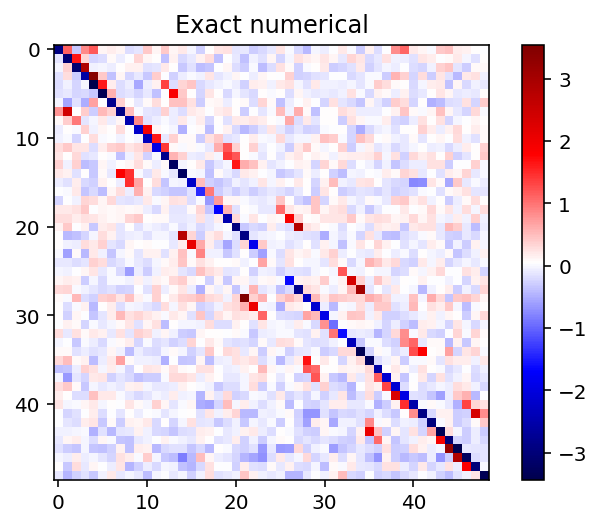

In [192]:
title('Exact numerical')
imshow(L_linreg, cmap='seismic')#, vmin = -m, vmax = m)
colorbar()

# Learning $L_\theta$ from small rotations
Now we learn $L_\theta$ from pairs of images where one has a small, fixed rotation relative to the other. 
This is simply using L-conv for linear regression, trained via SGD.
\begin{align}
    F(h) &= h+ L_ih\bar{\epsilon}^i %= (I+L_ihM^i)\cr
    %M^i &= W^i [\tilde{W}^0]^{-1}
\end{align}

In [193]:
s = dataset1[0][0].shape
d = prod(s)
lc = Lconv_core(d=d,num_L=1, cin=1, cout=1)
model = nn.Sequential(
    nn.Flatten(2),
    lc,
    Reshape(s)
).to(device)

In [194]:
optimizer = optim.Adam(model.parameters(),lr = 1e-2)


In [195]:
t = trainer(model, device, optimizer, train_loader=train_loader, test_loader=test_loader, 
            #dataset_class=AugRotMNIST__0, #dataset, 
            loss_func=F.mse_loss)

In [200]:
t.fit(20)

Train Epoch: 1 [=========>] 1.7s [49920/50000 (100%)]	Loss: 5.285e-11
Training: loss: 1.912e-13, Acc: 0.00%
Test loss: 2.148e-09, Test acc.: 0.00%
Train Epoch: 2 [=========>] 1.7s [49920/50000 (100%)]	Loss: 9.992e-12
Training: loss: 5.941e-14, Acc: 0.00%
Test loss: 5.974e-10, Test acc.: 0.00%
Train Epoch: 3 [=========>] 1.7s [49920/50000 (100%)]	Loss: 3.099e-13
Training: loss: 9.645e-15, Acc: 0.00%
Test loss: 1.043e-11, Test acc.: 0.00%
Train Epoch: 4 [=========>] 1.7s [49920/50000 (100%)]	Loss: 8.616e-15
Training: loss: 2.998e-16, Acc: 0.00%
Test loss: 4.285e-13, Test acc.: 0.00%
Train Epoch: 5 [=========>] 1.7s [49920/50000 (100%)]	Loss: 1.787e-15
Training: loss: 5.932e-17, Acc: 0.00%
Test loss: 9.503e-14, Test acc.: 0.00%
Train Epoch: 6 [=========>] 1.7s [49920/50000 (100%)]	Loss: 8.681e-16
Training: loss: 3.328e-17, Acc: 0.00%
Test loss: 6.067e-14, Test acc.: 0.00%
Train Epoch: 7 [=========>] 1.8s [49920/50000 (100%)]	Loss: 6.981e-16
Training: loss: 3.963e-17, Acc: 0.00%
Test loss:

Text(0.5, 0, 'Epochs')

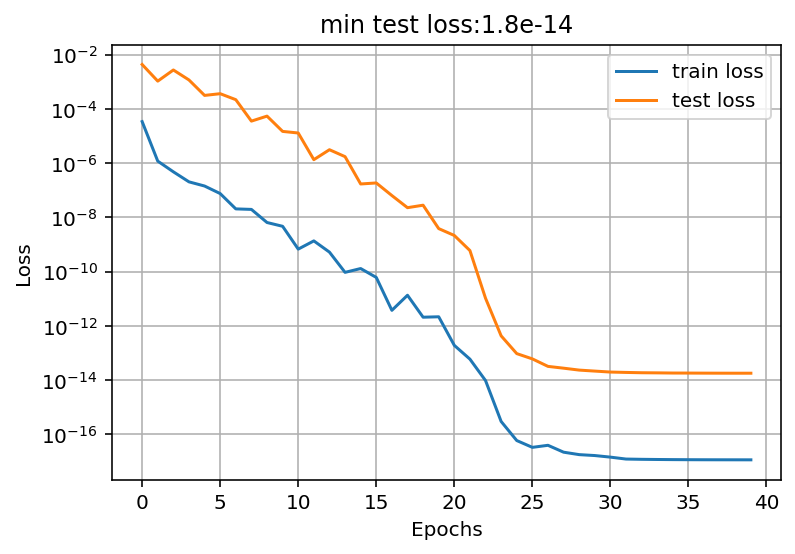

In [203]:
for k in ['train loss', 'test loss']:
    plot(t.history[k], label=k)
    
title(f'min test loss:{min(t.history["test loss"]):.3g}')
legend()
grid()
yscale('log')
ylabel('Loss')
xlabel('Epochs')

In [201]:
L_small = (lc.L*lc.Wi).detach().cpu().numpy()[0] / ang
lc.Wi

Parameter containing:
tensor([[[-1.1799]]], device='cuda:0', requires_grad=True)

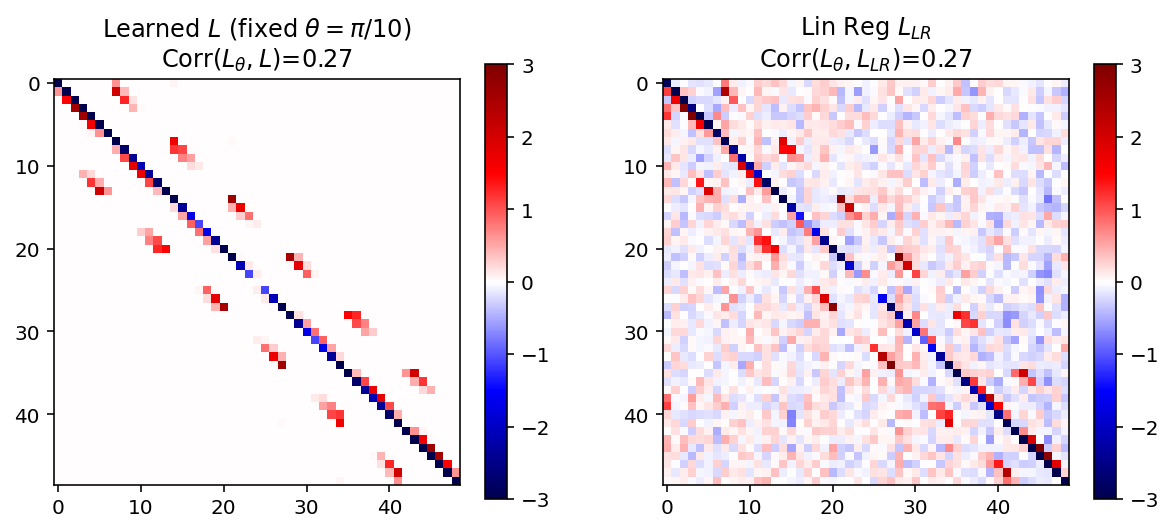

In [202]:
m = 3

figure(figsize=(10,4))
subplot(121)
title(r'Learned $L$ (fixed $\theta=\pi/%d$)'%(ang_n)+\
      '\n'+r'Corr($L_\theta,L$)=%.2f'% coscorr(L_rot, L_small))
imshow(L_small, cmap='seismic', vmin = -m, vmax = m)
colorbar()

subplot(122)
title('Lin Reg $L_{LR}$'+\
      '\n'+r'Corr($L_\theta,L_{LR}$)=%.2f'% coscorr(L_rot, L_linreg.T))
imshow(L_linreg.T, cmap='seismic', vmin = -m, vmax = m)
colorbar()

# savefig('./figs2/L-so2-pi-10.pdf')
# savefig('./figs2/L-so2-pi-10.png', dpi=300)

# Mutiangle augmentation
In this task we predict the angle by comparing an unrotated input $x$ with a rotated one $y$. 
Let $F(x)$ denote the action of the L-conv layers on $x$. 
Comparing $F(x)$ with the rotated input $y$ should yield the correct angle $t$. 
We do so by having multiple channels for $W$. 
Each output channel $F(x)_a$ is one rotated version of the input using shared $L$. 
These outputs should be compared with $y$, which can be done as $f_a = y^TF(x)_a$. 

## Experiment: Learning the rotation angle
We feed a pair of images to the model, original and rotated. 
We want L-conv to learn the rotation angle. 

We can start by having cxc matrices for $W^i$ and first pass copies of the input to it. 
In the end we take the inner product with the rotated input and the outputs of the network. 
We then pass this through a classification or regression layer to read the angle. 

In [204]:
class RandRot(datasets.VisionDataset):
    def __init__(self,*args,dataseed=0,N=50000,size=(7,7),max_angle = np.pi,
                 train=True,**kwargs):
        super().__init__(*args,**kwargs)
        if not train: 
            dataseed += 1
            N = int(0.2*N)
        torch.manual_seed(dataseed)
        angles = torch.rand(N)*max_angle
        self.angles = angles[:,newaxis] #
        self.data = torch.rand(N,1,*size)-.5
        print(N, self.data.shape)
        with torch.no_grad():
            # Build affine matrices for random translation of each image
            affineMatrices = torch.zeros(N,2,3)
            affineMatrices[:,0,0] = angles.cos()
            affineMatrices[:,1,1] = angles.cos()
            affineMatrices[:,0,1] = angles.sin()
            affineMatrices[:,1,0] = -angles.sin()
            # affineMatrices[:,0,2] = -2*np.random.randint(-self.max_trans, self.max_trans+1, bs)/w
            # affineMatrices[:,1,2] = 2*np.random.randint(-self.max_trans, self.max_trans+1, bs)/h
            
            flowgrid = F.affine_grid(affineMatrices, size = self.data.size())
            self.data_rot = F.grid_sample(self.data, flowgrid)
    def __getitem__(self,idx):
        return (self.data[idx], self.data_rot[idx]), self.angles[idx]
    
    def __len__(self):
        return len(self.data)
    
    def default_aug_layers(self):
        return RandomRotateTranslate(0)# no translation



In [205]:
class Net(nn.Module):
    def __init__(self,d,c,device,k=1, rec=1, hid = 5):
        super().__init__()
        self._rec = rec
        self._c = c
#         with torch.no_grad():
        self.ones = torch.ones((1,c,1)).to(device)
        self.LC = Lconv_core(d=d,num_L=k,cin=c,cout=c)
        self.flat = nn.Flatten(2)
        self.lin1 = nn.Linear(c,hid)
        self.out = nn.Linear(hid,1)
        
    def forward(self, inp):
        x,y = inp
        # x,y->(batch, channel, flat_d)
        x = self.flat(x)
        y = self.flat(y)
        # copy input to c channels
        x = x * self.ones
        # pass through L-conv
        for _ in range(self._rec):
            x = self.LC(x)
        x = torch.einsum('bcd,bad->bc', x, y)
        x = F.tanh(x)
        x = self.lin1(x)
        x = F.tanh(x) 
        return self.out(x)

In [206]:
dataset = RandRot 
batch_size = 16
test_batch_size = 1000
device = torch.device("cuda")
# device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
# if use_cuda:
cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

kws = dict(size=(7,7),
          max_angle = np.pi/8)

dataset1 = dataset('../data', train=True, **kws)
dataset2 = dataset('../data', train=False, **kws)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


50000 torch.Size([50000, 1, 7, 7])
10000 torch.Size([10000, 1, 7, 7])


/home/nima/pyenvs/ML_tests-1/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/nima/pyenvs/ML_tests-1/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [207]:
for (x,y),th in train_loader:
    x = x.to(device)
    y = y.to(device)
    break

In [208]:
x.shape, y.shape, th.shape

(torch.Size([16, 1, 7, 7]), torch.Size([16, 1, 7, 7]), torch.Size([16, 1]))

In [265]:
s = dataset1.data[0].shape
d = prod(s)
# lc = Lconv_2(k=2,d=d, cin=1, cout=1, rank=50)
rec = 3
model = Net(d,10,k=1,device=device,rec=rec).to(device)

# model = nn.Sequential(
#     nn.Flatten(2),
#     *(rec*(lc,)),
#     Reshape(s)
# ).to(device)

In [267]:
optimizer = optim.Adam(model.parameters(),lr = 1e-3)


In [268]:
t = trainer(model, device, optimizer, train_loader=train_loader, test_loader=test_loader, 
            #dataset_class=AugRotMNIST__0, #dataset, 
            loss_func=F.mse_loss)

In [269]:
dataset1.data.device

device(type='cpu')

In [270]:
t.fit(10)

/home/nima/pyenvs/ML_tests-1/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [=========>] 8.0s [6240/50000 (100%)]	Loss: 0.0002899
Training: loss: 0.0003859, Acc: 0.00%
Test loss: 0.0004376, Test acc.: 0.00%
Train Epoch: 2 [=========>] 7.9s [6240/50000 (100%)]	Loss: 0.0002815
Training: loss: 1.503e-05, Acc: 0.00%
Test loss: 0.0001817, Test acc.: 0.00%
Train Epoch: 3 [=========>] 7.7s [6240/50000 (100%)]	Loss: 0.0001618
Training: loss: 9.241e-06, Acc: 0.00%
Test loss: 0.0001674, Test acc.: 0.00%
Train Epoch: 4 [=========>] 7.5s [6240/50000 (100%)]	Loss: 3.136e-05
Training: loss: 7.437e-06, Acc: 0.00%
Test loss: 0.0001137, Test acc.: 0.00%
Train Epoch: 5 [=========>] 7.5s [6240/50000 (100%)]	Loss: 0.0002264
Training: loss: 6.523e-06, Acc: 0.00%
Test loss: 0.0001023, Test acc.: 0.00%
Train Epoch: 6 [=========>] 7.6s [6240/50000 (100%)]	Loss: 8.259e-05
Training: loss: 5.921e-06, Acc: 0.00%
Test loss: 9.492e-05, Test acc.: 0.00%
Train Epoch: 7 [=========>] 7.6s [6240/50000 (100%)]	Loss: 4.221e-05
Training: loss: 5.508e-06, Acc: 0.00%
Test loss: 9.566e

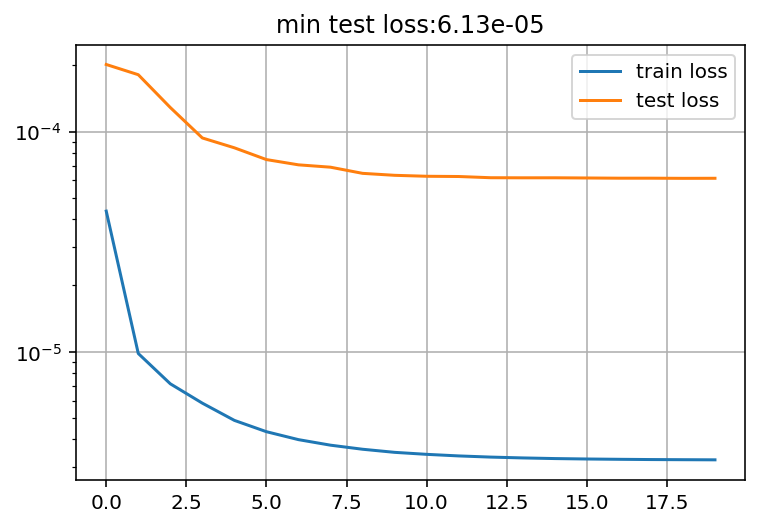

In [220]:
for k in ['train loss', 'test loss']:
    plot(t.history[k], label=k)
    
title(f'min test loss:{min(t.history["test loss"]):.3g}')
legend()
grid()
yscale('log')

In [221]:
l = model.LC
# L1 = (1*torch.eye(len(l.L[0])).to(device) + l.L*l.Wi[0,0] ).detach().cpu().numpy()[0]
Ls = l.L.detach().cpu().numpy()
# L= Ls[0]

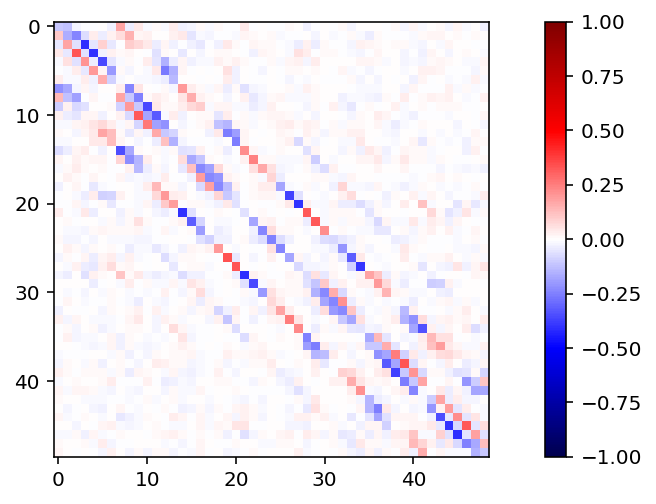

In [222]:
figure(figsize=(10,4))
for i in range(len(Ls)):
    subplot(1,len(Ls), i+1)
    imshow(Ls[i].T,cmap='seismic', vmin = -1, vmax = 1)
    colorbar()
    


In [223]:
coscorr(Ls[0], L_rot)

-0.7020861964579547

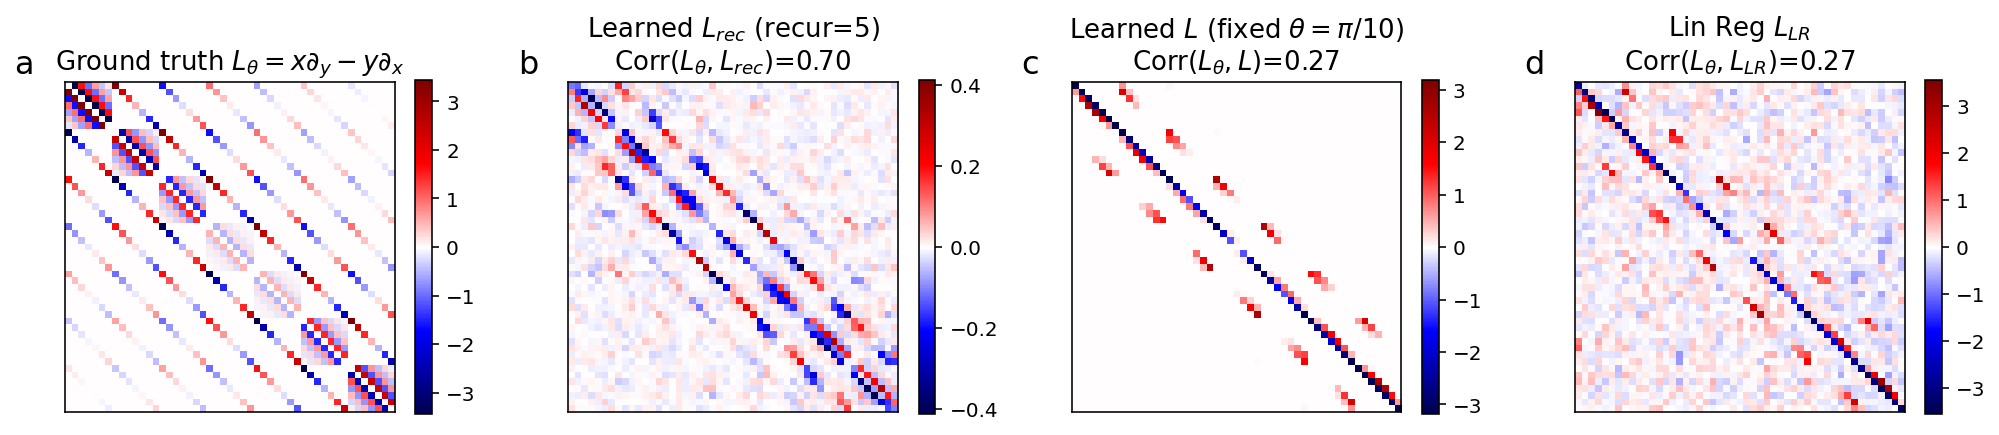

In [261]:
m = 3

figure(figsize=(14,3))

dat = [[L_rot, r'Ground truth $L_\theta=x\partial_y-y\partial_x$'],
       [Ls[0].T,'Learned $L_{rec}$ (recur=%d)'%rec 
        +'\n'+r'Corr($L_\theta,L_{rec}$)=%.2f'% coscorr(L_rot, Ls[0].T)],
       [L_small,r'Learned $L$ (fixed $\theta=\pi/%d$)'%(ang_n)
        +'\n'+r'Corr($L_\theta,L$)=%.2f'% coscorr(L_rot, L_small)],
       [L_linreg.T,'Lin Reg $L_{LR}$'
        +'\n'+r'Corr($L_\theta,L_{LR}$)=%.2f'% coscorr(L_rot, L_linreg.T)],
      ]

labs = 'abcd'
for ii in arange(len(dat)):
    subplot(1,len(dat),ii+1)
    l,txt = dat[ii]
    m = max(abs(l.ravel()))
    imshow(l,cmap = 'seismic',vmin=-m, vmax=m)
    colorbar()
    title(txt, size = 13);
    # abcd
    text(-8,-1.8,labs[ii], fontdict={'size':16,'weight':1})
    xticks([])
    yticks([])


tight_layout()
savefig('./figs2/L-so2-full.pdf')
savefig('./figs2/L-so2-full.png', dpi=300)



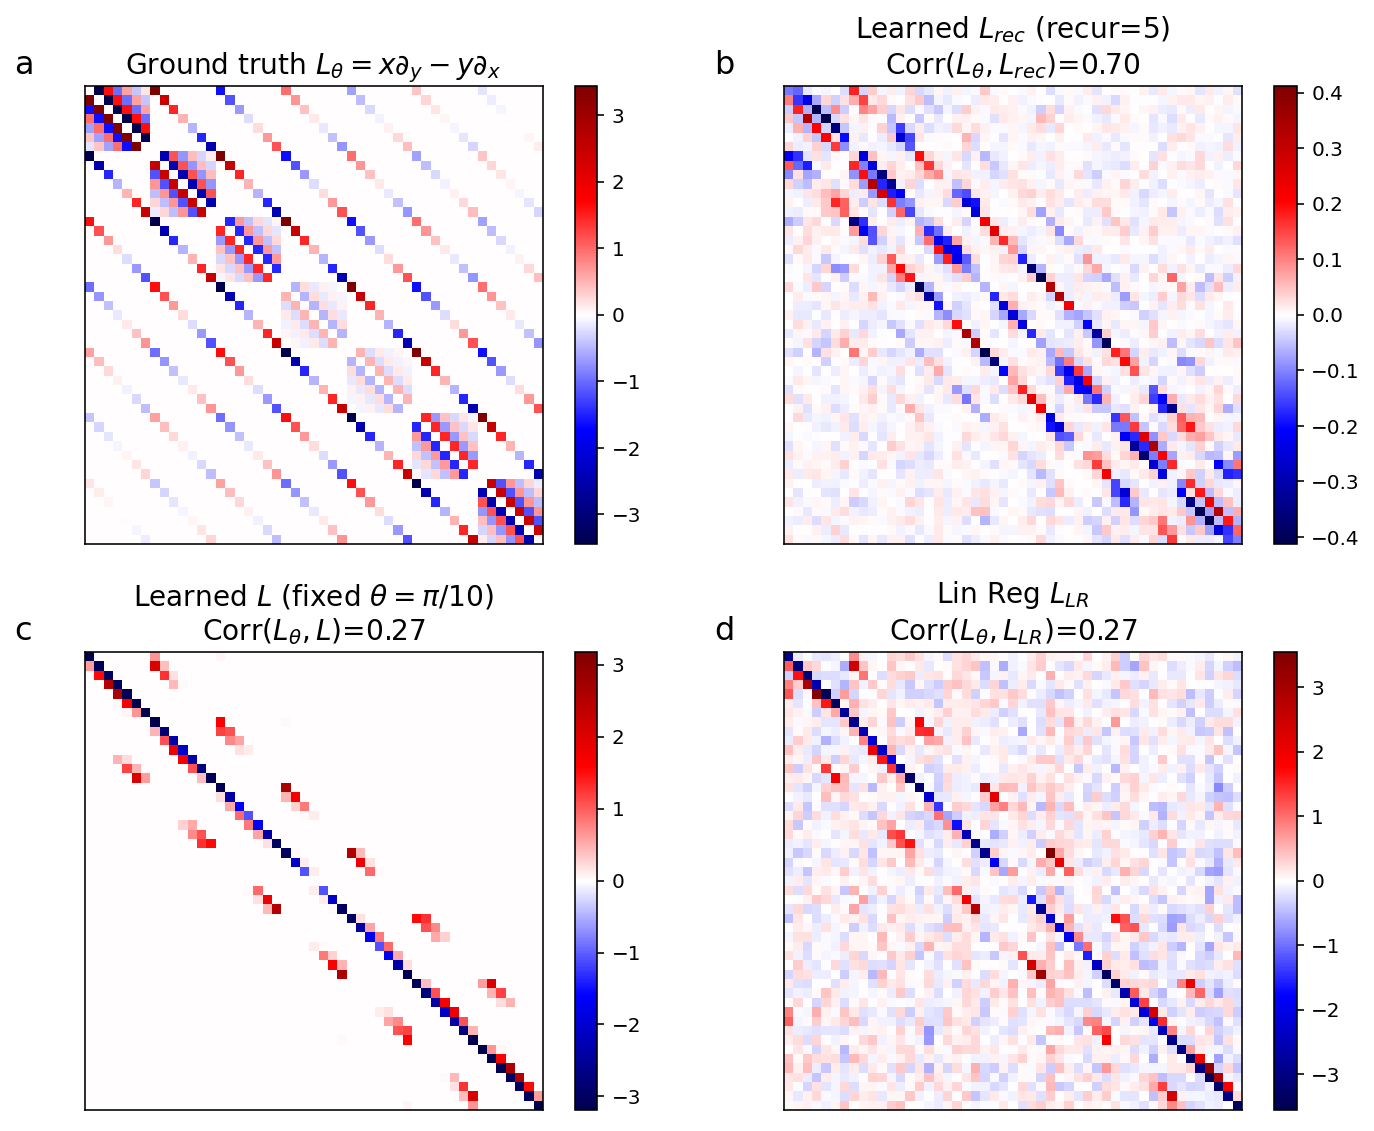

In [264]:
m = 3

figure(figsize=(10,8))

dat = [[L_rot, r'Ground truth $L_\theta=x\partial_y-y\partial_x$'],
       [Ls[0].T,'Learned $L_{rec}$ (recur=%d)'%rec 
        +'\n'+r'Corr($L_\theta,L_{rec}$)=%.2f'% coscorr(L_rot, Ls[0].T)],
       [L_small,r'Learned $L$ (fixed $\theta=\pi/%d$)'%(ang_n)
        +'\n'+r'Corr($L_\theta,L$)=%.2f'% coscorr(L_rot, L_small)],
       [L_linreg.T,'Lin Reg $L_{LR}$'
        +'\n'+r'Corr($L_\theta,L_{LR}$)=%.2f'% coscorr(L_rot, L_linreg.T)],
      ]

labs = 'abcd'
for ii in arange(len(dat)):
    subplot(2,len(dat)//2,ii+1)
    l,txt = dat[ii]
    m = max(abs(l.ravel()))
    imshow(l,cmap = 'seismic',vmin=-m, vmax=m)
    colorbar()
    title(txt, size = 14);
    # abcd
    text(-8,-1.8,labs[ii], fontdict={'size':16,'weight':1})
    xticks([])
    yticks([])


tight_layout()
savefig('./figs2/L-so2-full-2.pdf')
savefig('./figs2/L-so2-full-2.png', dpi=300)

